In [259]:
import gseapy; import pandas as pd; import shutil
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm # recommended import according to the docs
from beeswarm import *
import seaborn.apionly as sns
from ggplot import *
from scipy.stats import ttest_ind, ttest_ind_from_stats
import statsmodels.api as sm
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#sns.set_style("ticks")

In [262]:
def S2N(CCLE,sensitive,resistant): # not getting correct values -- too high
    data_s = CCLE[CCLE["Cell.Line"].isin(sensitive)]
    data_r = CCLE[CCLE["Cell.Line"].isin(resistant)]
    sens_genes_mean = []; sens_genes_sd = []
    resi_genes_mean = []; resi_genes_sd = []
    genes_p = []
    for i in range(1 , data_s.shape[1]):
        sens_genes_mean.append(np.mean(data_s[data_s.columns[i]]))
        sens_genes_sd.append(np.std(data_s[data_s.columns[i]], axis = 0, ddof = 1))
        resi_genes_mean.append(np.mean(data_r[data_r.columns[i]]))
        resi_genes_sd.append(np.std(data_r[data_r.columns[i]], axis = 0, ddof = 1))
        genes_p.append(sm.stats.ttest_ind(data_s[data_s.columns[i]],data_r[data_r.columns[i]],alternative="two-sided")[1])
    sens_genes_mean = np.array(sens_genes_mean);sens_genes_sd = np.array(sens_genes_sd)
    resi_genes_mean = np.array(resi_genes_mean);resi_genes_sd = np.array(resi_genes_sd)
    S2N = (sens_genes_mean - resi_genes_mean) / (sens_genes_sd + resi_genes_sd)
    S2N_df = pd.DataFrame({"S2N":S2N, "pvalue":genes_p,
                           "genes":CCLE.columns.tolist()[1:],
                           "sens_mean":sens_genes_mean,
                           "sens_sd":sens_genes_sd,
                           "resi_mean":resi_genes_mean,
                           "resi_sd":resi_genes_sd})
    return S2N_df

In [151]:
def dropUnnamedColumns(DataFrame):
    cols = DataFrame.columns
    indexes = []
    cnt=0
    for i in cols:
        if "Unnamed" in i:
            indexes.append(cnt)
        cnt+=1
    return DataFrame.drop(cols[indexes],axis=1)

In [263]:
test = pd.read_csv("/Users/brentkuenzi/Documents/Drug SVM/R_analysis/CCLE.txt",sep="\t")
test = dropUnnamedColumns(test)
test = test.drop_duplicates(subset=["Cell.Line"])
test_S2N = S2N(test,["NCIH1155_LUNG","NCIH460_LUNG","NCIH1299_LUNG"],["NCIH650_LUNG","NCIH23_LUNG","NCIH661_LUNG","HCC2935_LUNG"])

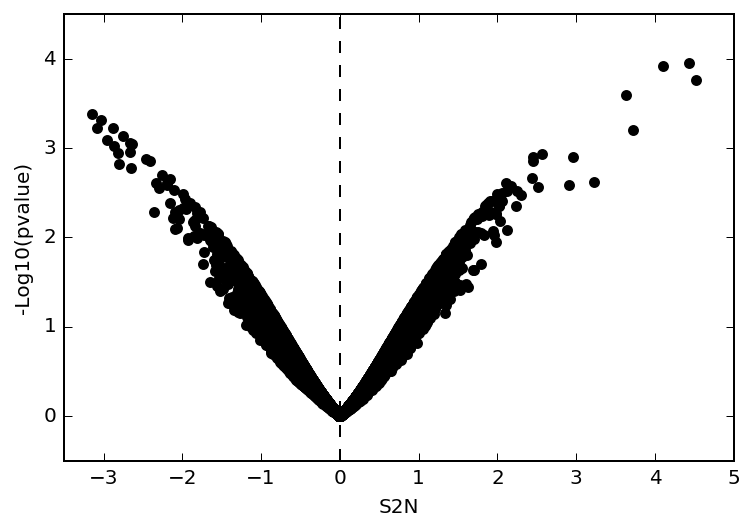

In [275]:
test_S2N["-log10(pvalue)"] = -np.log10(test_S2N["pvalue"])
plt.scatter(data=test_S2N,x="S2N",y="-log10(pvalue)",color="black")
plt.xlim(-3.5,5); plt.ylim(-0.5,4.5)
plt.ylabel("-Log10(pvalue)"); plt.xlabel("S2N")
plt.axvline(0,color="black",ls="dashed")

In [2]:
def KStestRanked(gene_subset,full_set,column,identifier,permutations=5000,direction="up"):
    """
    This function performs a modified Kolmogorov Smirnov test (ranked). gene_subset is
    a list of genes to be tested. full_set is a Pandas dataframe. column is the
    column of the dataset to rank on. Permutations is number of permutations of
    random sampling for p-value estimation. direction is for determination of
    degree of up or downregulation.

    This modification is distinct from a standard KS test in several ways: First, when
    comparing a large distribution to a small distribution in a standard KS test, the NULL
    hypothesis is biased towards being rejected, and thus introduce false positives. Second,
    a ranked KS test allows for the preferential ranking of sets that are separated from the
    background at the tails of the distribution.
    """
    # sort gene_subset and full_set
    t = len(gene_subset); n = len(full_set); u_list = []; cnt = 1
    j = lambda x: full_set[gene_subset in full_set[identifier]].index(x)
    v_j = lambda x: full_set[identifier].index(x)
    if direction == "up":
        for i in gene_subset:
            u_list.append((j(i)/t)-(v_j(i)/n))
        u = max(u_list)
    else:
        for i in gene_subset:
            u_list.append((v_j(i)/n)-((j(i)-1)/t))
        u = max(u_list)
    perm = 0
    u_instances = 0
    while perm < permutations:
        random = full_set.sample(frac=(t/n)) # do I need to sort this?
        u_list = []
        for i in random:
            if direction == "up":
                u_list.append((j(i)/t)-(v_j(i)/n)) # need to fix for random sampling
            else:
                u_list.append((v_j(i)/n)-((j(i)-1)/t)) # need to fix for random sampling
        u_random = max(u_list)
        if u_random > u:
            u_instances += 1
        perm += 1
    pvalue = u_instances / permutations
    return pvalue

In [5]:
def KEGGanalysis(genes,cutoff=0.1,gene_sets="KEGG_2016",description="pathway"):
    """
    This function performs KEGG analysis on a gene set. Input is a list gene names.
    """
    gseapy.enrichr(gene_list=genes, description=description, gene_sets=gene_sets, outdir='test',cutoff=cutoff)
    output = pd.read_csv("~/test/"+gene_sets+".pathway.enrichr.reports.txt",sep="\t")
    shutil.rmtree("test")
    return output
def PlotKEGG(KEGGobject,color="black",x="P-value",abline = 0.05,abline_color="red"):
    """
    This function visualizes the output from KEGGanalysis. Input is pandas DF from KEGGanalysis
    """
    KEGGobject["-log10(pvalue)"] = -np.log10(KEGGobject[x])
    plot = KEGGobject.sort_values(x)
    objects = plot["Term"]
    objects2 = []
    for i in objects:
        objects2.append(i.split("_")[0])
    y_pos = list(range(len(plot["-log10(pvalue)"])))
    performance = plot["-log10(pvalue)"]
    fig, ax = plt.subplots()
    ax.barh(y_pos, performance, align='center', alpha=0.5,color=color)
    ax.invert_yaxis()
    ax.set_yticks(y_pos)
    ax.set_yticklabels(objects2)
    ax.set_xlabel('-Log10(P-value)')
    plt.axvline(x=abline,color=abline_color)
    plt.show()

In [ ]:
def ElasticNet:
    #function

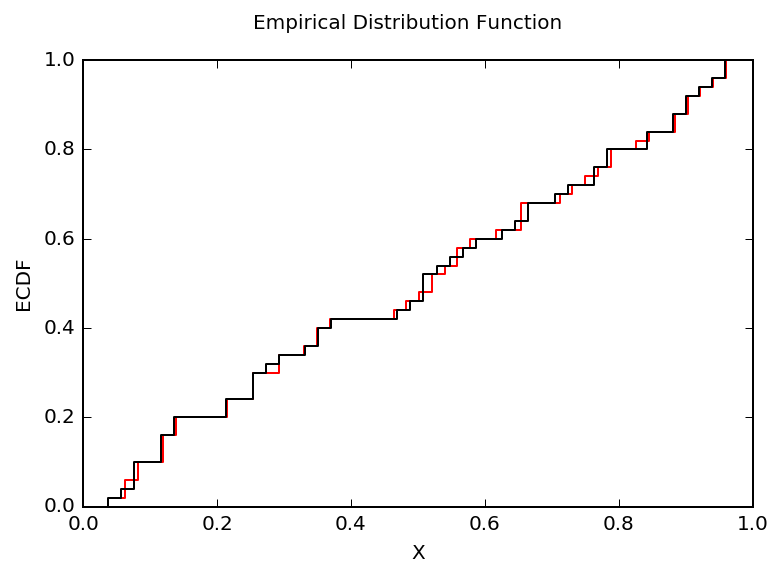

In [28]:
# Empirical distribution function
# Wont work in atom but should in jupyter
# make into a function for ranked KS (x=np.linspace(1,len(sample))) and KS (see below)
#def plotECDF(sample1,sample2,x)

sample = np.random.uniform(0, 1, 50)
sample2 = np.random.uniform(0, 50, 900)
ecdf = sm.distributions.ECDF(sample)
ecdf2 = sm.distributions.ECDF(sample2)

x = np.linspace(min(sample), max(sample))
y = ecdf(x)
x2 = np.linspace(min(sample2), max(sample))
y2 = ecdf(x2)
plt.step(x, y,color="red")
plt.step(x2,y2,color="black")
plt.ylabel("ECDF"); plt.xlabel("X")
plt.suptitle("Empirical Distribution Function")
plt.show()

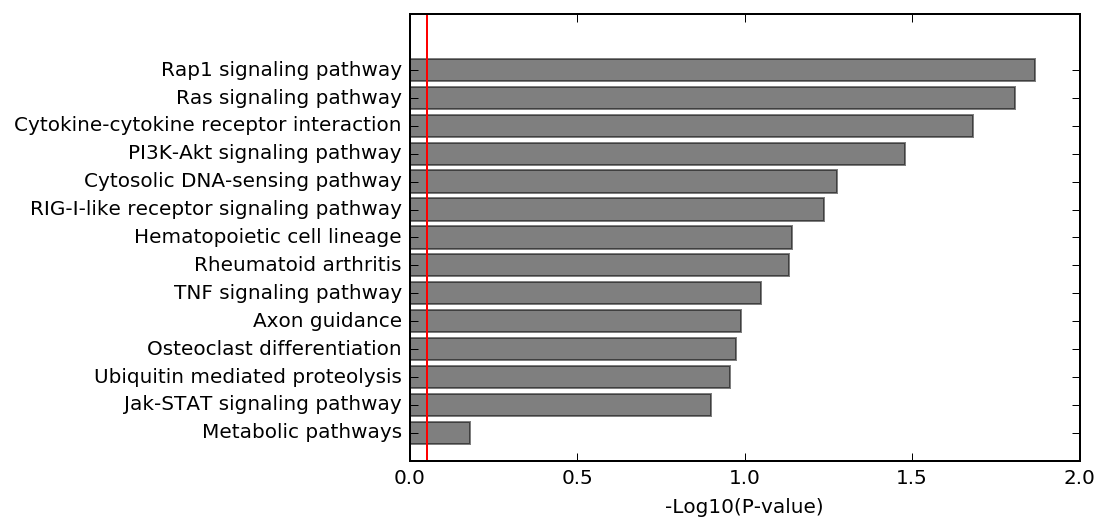

In [7]:
gl = ['SCARA3', 'LOC100044683', 'CMBL', 'CLIC6', 'IL13RA1', 'TACSTD2', 'DKKL1', 'CSF1',
     'SYNPO2L', 'TINAGL1', 'PTX3', 'BGN', 'HERC1', 'EFNA1', 'CIB2', 'PMP22', 'TMEM173']
pathways = KEGGanalysis(gl,gene_sets="KEGG_2016")
PlotKEGG(pathways)

In [70]:
pathways.shape

(14, 10)

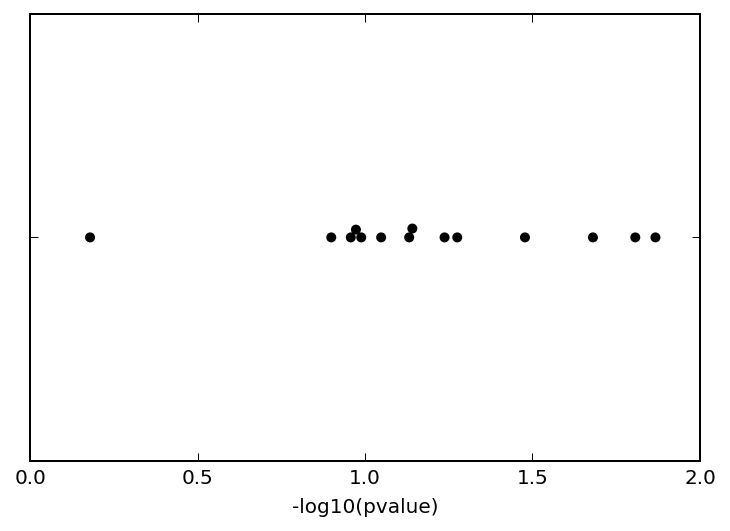

In [24]:
sns.swarmplot(data = pathways, x="-log10(pvalue)",color="black",label="test")